# Task 1
Data Gathering and Pre-processing

API connection and data extraction from the data source

In [2]:
# Uncomment during first run:
# !pip install tweepy
# !pip install textblob
# !pip install wordcloud
# Imports
import os
import re
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pathlib import Path
from wordcloud import WordCloud
from textblob import TextBlob

In [3]:
def get_twitter_auth():
    # Access
    api_key = "cW0baXByVgPOTGYxtMJemj4oZ"
    api_secret = "ktRwML34E5fniXClpSqnXkFytkOTFCZdS9sTM5LcaRY87WnP1K"
    access_token = "1448619504293060609-eMsiWzCxjCp6PBD6c7qCA7yfWNjIHV"
    access_token_secret = "yH5tunDKqchrb912RP2bH78mKGrLqnm9nh1ccLbF49RUD"

    auth = tweepy.OAuthHandler(api_key, api_secret)
    auth.set_access_token(access_token, access_token_secret)

    return tweepy.API(auth, wait_on_rate_limit = True)

def read_twitter_data(profiles):
    df = pd.DataFrame()
    # If the file already exists, load it to a dataframe
    if generate_twitter_data is False or Path(file_path).is_file():
        # If the file exists
        if Path(file_path).is_file():
            print("Reading twitter data from file")
            # Read the data file in
            tempdf = pd.read_csv('data.csv')
            # Remove title row
            tempdf = tempdf[tempdf['User'] != "User"]

            for name in profiles:
                df = df.append(tempdf[tempdf['User'] == name])
    else:
        print("File doesn't exist, generating data")
        # Get 300 tweets for each user
        df = get_users_twitter_data(profiles, 300)

    twitter_data_file_exists = True
    return df

def get_users_twitter_data(names, n):
    """ Gets twitter data of each user in the list of names provided"""
    print("Getting Twitter Data")
    print(f"Screen name\tFollowers")
    
    headers = True
    df = pd.DataFrame()

    for name in names:
        print(name + "\t" + str(get_user_followers(name)))

        # Create lists for prominent tweet data
        tweets, likes, time, retweets, lat, lng, create_time = get_user_tweets_likes_time(n, name);
        # Create dataframe with this list data
        temp = pd.DataFrame({'create_time': create_time, 'tweets':tweets, 'likes':likes, 'retweets':retweets, 'time':time, 'latitude':lat, 'longitude':lng})
        temp['User'] = name
        # append data to csv
        temp.to_csv(file_path, mode='a', header=headers, index = False)
        df = df.append(temp)
        headers = False

    return df

def get_user_tweets_likes_time(n, name):
    """ Gets n numbers of tweets, likes and the created time of those tweets for user provided through 'name'
    """
    tweets = []
    likes = []
    time = []
    retweets = []
    lng = []
    lat = []
    create_time = []

    for i in tweepy.Cursor(api.user_timeline, screen_name = name, tweet_mode= "extended").items(n):
        latitude = None
        longitude = None
        tweets.append(i.full_text)
        likes.append(i.favorite_count)
        time.append(i.created_at)
        retweets.append(i.retweet_count)
        create_time.append(i.created_at)
        if i.place is not None:
            coords = i.geo['coordinates']
            latitude = coords[0]
            longitude = coords[1]
        lat.append(latitude)
        lng.append(longitude)
    return tweets, likes, time, retweets, lat, lng, create_time

def get_user_followers(name):
    user = api.get_user(screen_name = name)
    return user.followers_count

def get_user_tweets(n, name):
    tweets = []
    for i in tweepy.Cursor(api.user_timeline, screen_name = name, tweet_mode= "extended").items(n):
        tweets.append(i.full_text)
    return tweets

def get_user_mentions_by_user(user : str, data : pd.DataFrame()) -> pd.DataFrame():
    """Gets a list of users mentioned throughout user's tweets

    Args:
        user (str): The user we want to get information from
        data (pd.DataFrame): The data we're extracting the usernames from

    Returns:
        pd.DataFrame: The dataframe containing the mentioned usernames in the tweets and the number of times each name has been mentioned
    """
    # Get a single users data
    tempdf = df[df['User'] == user]
    # Filter tweets with @ symbol (Typically used to 'mention' people in a tweets list)
    tempdf = tempdf[tempdf.tweets.str.contains("@")]
    # print(tempdf)
    return tempdf

def get_top_n_tweets(users : list, n : int) -> pd.DataFrame():
    """Gets the top n tweets for each user

    Args:
        users (list): List of users we want to retrieve tweets from
        n (int): Number of tweets we want to retrieve

    Returns:
        pd.DataFrame(): Dataframe containing tweet data for each user in users
    """
    # Get a single users tweets
    data = read_twitter_data(users)
    df = pd.DataFrame()
    for user in users:
        temp = data[data['User'] == user]
        temp = temp.sort_values(by = 'likes', ascending=False)
        df = df.append(temp[:n])
    # Sort the dataframe by favourite/like count (metric to define popularity)
    # data = data.sort_values(by='likes', ascending = False)
    # Remove everything except first n get_top_n_tweets
    n = n * len(users)
    data = df[:n]
    # Return n tweets
    return data

def get_top_n_retweeted_tweets(users:list, n:int) -> pd.DataFrame():
    """Get the top quantity of tweets each user has that received the most retweets.
    This removes any tweets the user hasn't made themselves (Tweets they've retweeted themselves)
    Args:
        users (list): the users we want to check for retweet counts
        n (int): top number of tweets for each user

    Returns:
        pd.DataFrame: Dataframe containing top n retweeted tweets for each user
    """
    # Get users tweets
    data = read_twitter_data(users)
    # Remove retweets from dataframe for every user
    data = remove_retweeted_tweets(data)

    df = pd.DataFrame()
    for user in users:
        temp = data[data['User'] == user]
        # Sort the dataframe by retweet count (metric to define popularity)
        temp = temp.sort_values(by = 'retweets', ascending=False)
        # Append n tweets (Should be the most retweeted tweets after sorting)
        df = df.append(temp[:n])
    n = n * len(users)
    # Remove everything except first n get_top_n_tweets
    data = df[:n]
    # Return n tweets
    return data

def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity
    
# Plot functions
def plot_sum_of_likes_per_user(data):
    # Retrieve each unique username
    for user in df['User'].unique():
        tweets = df[df['User'] == user]
        total_likes = tweets['likes'].sum()
        plt.bar(x = tweets['User'],height=total_likes, width = 0.6)
    plt.title("Sum of likes per user")
    plt.xlabel("Users")
    plt.ylabel("Likes")
    plt.show()

def plot_likes_for_tweets_over_time(data):
    users = df['User'].unique()
    print(users)
    fig, ax = plt.subplots(nrows=int(len(users)/2), ncols=2, figsize=(18, 5))
    i = 0
    j = 0
    count = 0;
    for user in users:
        tweets = df[df['User'] == user]
        # print(j, i, count)
        ax[j, i].bar(tweets['time'],tweets['likes'], label = user)
        if i < 1:
            i+= 1
        else:
            i = 0
            j += 1
    print(tweets['likes'].min(), tweets['likes'].max())
    plt.xticks(np.arange(tweets['likes'].min(), tweets['likes'].max(), 10000))
    plt.show()

def plot_followers_per_user(x):
    y = []
    # For each unique user
    for user in df['User'].unique():
        # Gather all tweets for that user
        tweets = df[df['User'] == user]
        # Get the total number of followers for this user
        total_followers = get_user_followers(user)
        y.append(total_followers)
    
    plt.barh(x, y)
    # plt.bar(x, y)
    
    plt.title("Followers per user")
    plt.xlabel("Followers")
    plt.ylabel("Users")
    # plt.xticks(np.arange(0, 10000000, 10))
    plt.xscale('log')
    plt.margins(y=0.1)
    for index, value in enumerate(y):
        plt.text(value, index, str(value))
    plt.show()

def plot_top_most_mentioned_users(names):
    """Retrieves the top most mentioned users from specific user profiles
    names, sum of names
    Args:
        names (list): list of user profiles we're deriving mention data from
    """
    fig, axs = plt.subplots(2, 2, figsize=(30, 12))
    j = 0
    i = 0
    for user in names:
        # Calculate total tweets we're deriving the following information from
        tweet_count = len(df[df['User'] == user])
        # Get the 'mention' data for the specified user
        tempdf = get_user_mentions_by_user(user, df)
        # Extracts all user mentions from tweets and stores to new column
        tempdf['mention'] = tempdf.tweets.str.findall(r'(?<![@\w])@(\w{1,25})').apply(',\n'.join)
        # Calculate the number of mentions each account has by this user
        mention_values = tempdf['mention'].value_counts()
        # Retrieve each unique mentioned user from the list
        mention_unique = tempdf['mention'].unique()
        
        # Create bar chart with this data
        # axs[j, i].figure(figsize = (16,6))
        # Plot the top 10 most mentioned users
        axs[j, i].bar(mention_unique[0:10], mention_values[0:10], width = 0.5)
        # Rotate labels for easier visual interpretation
        # Add 5 'ticks' to y axis to make graph easier to perceive
        # axs[j, i].yticks(np.arange(0, mention_values.max()+1, mention_values.max()/5))
        # axs.tick_params(labelrotation=45)
        # Add titles/axis labels
        axs[j, i].set_title(f"Most frequently mentioned users by {user} over {tweet_count} tweets")
        # axs[j, i].ylabel("Mentions")
        # axs[j, i].xlabel("Mentioned")
        fig.tight_layout()
        if i < 1:
            i+= 1
        else:
            i = 0
            j += 1
    # Show plot
    plt.show()

# Remove function(s)
def remove_retweeted_tweets(data):
    return data[~data.tweets.str.contains("RT")]

# Working on function here
def clean_tweet_data(tweet):
    """Cleans the tweet's text of clutter

    Args:
        tweet (str): tweet text

    Returns:
        str: the cleaned/refined tweet text
    """
    # Removes any @mentions
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)
    # Remove hashtags (# symbols)
    tweet = re.sub(r'#', '', tweet)
    # Remove retweet indicator, 'RT' from tweet text
    tweet = re.sub(r'RT[\s]+', '', tweet)
    # Remove urls from the tweet
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)
    return tweet

def drop_useless_rows(data):
    # Replace empty tweet strings to nan objects
    data['tweets'].replace('', np.nan, inplace=True)
    # Drop all rows with nan objects
    data = data.dropna()
    return data

def generate_word_clouds(names):
    for user in names:
        # Create temp dataframe containing this users tweet data
        tempdf = df[df['User'] == user]
        # Retrieve each word from this users tweets
        allWords = ' '.join([twts for twts in tempdf['tweets']])
        # Create a word cloud image using the words retrieved from tweets
        wordCloud = WordCloud(width = 1000, height = 500, random_state = 21, max_font_size = 119).generate(allWords)

        plt.imshow(wordCloud, interpolation = 'bilinear')
        plt.title(f"Word Cloud for {user}")
        plt.axis("off")
        plt.show()

In [4]:
generate_twitter_data = True
twitter_data_file_exists = False

file_dir = os.path.abspath('')
file_path = os.path.join(file_dir, 'data.csv')


# Names of the users we want to analyse
names = ["KSI", "eddiehallWSM", "terrycrews", "TheRock"]

# Get api twitter authenticated
# api = get_twitter_auth()


api = get_twitter_auth()
api.verify_credentials()


# Get twitter data
df = read_twitter_data(names)
print(str(df.shape[0]) + " tweets\t" + str(df.shape[1]) + " features\t" + str(int(df.shape[0]/len(names))) + " tweets per user")
df['latitude'].fillna(0, inplace = True)
df['longitude'].fillna(0, inplace = True)
# df[df['longitude'] != 0]


Reading twitter data from file
1300 tweets	8 features	325 tweets per user


Data Pre-processing from the data source to transform the original data into a Pandas dataframe

Perform a data cleansing activity considered relevant for the process (if any)

Provide the explanation of the process, the justification behind it, lessons learned and findings. 

# Task 2 - Exploratory Data Analysis

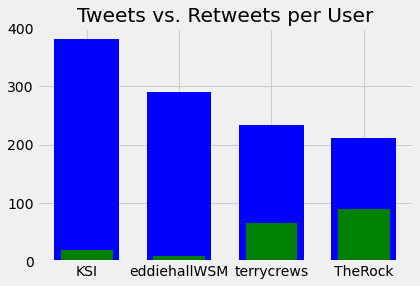

In [5]:
# Original tweets vs Retweets
original_tweet_count = []
df_copy = df.copy()
# Calculate total number of tweets per user
for user in names:
    tempdf = df_copy[df_copy['User'] == user]
    original_tweet_count.append(len(tempdf.index))

# Remove retweets from dataframe for every user
df_copy = df_copy[~df_copy.tweets.str.contains("RT")]

new_tweet_count = []
# Calculate new number of tweets per user
for user in names:
    tempdf = df_copy[df_copy['User'] == user]
    new_tweet_count.append(len(tempdf.index))

# Calculate number of retweets
retweets = []
zip_object = zip(original_tweet_count, new_tweet_count)
for list1_i, list2_i in zip_object:
    retweets.append(list1_i-list2_i)

# Plot the data to a bar chart
width = 0.7
indices = np.arange(len(new_tweet_count))

plt.bar(indices, new_tweet_count, width=width, color='b', label='Original Tweets')
plt.bar([i+0.25*width-width/4 for i in indices], retweets, width=0.8*width, color='g', label='Retweets')

plt.title("Tweets vs. Retweets per User")
plt.xticks(indices+width/2-width/2, names)
plt.show()


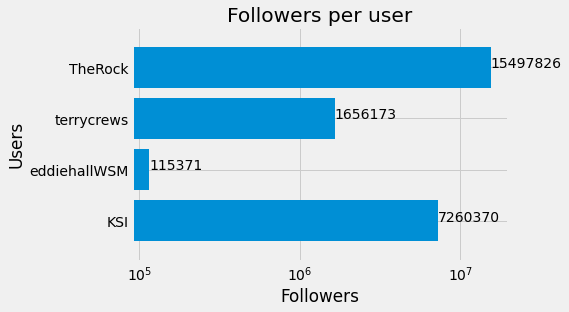

In [6]:
### Followers per user
names = ["KSI", "eddiehallWSM", "terrycrews", "TheRock"]
plot_followers_per_user(names)

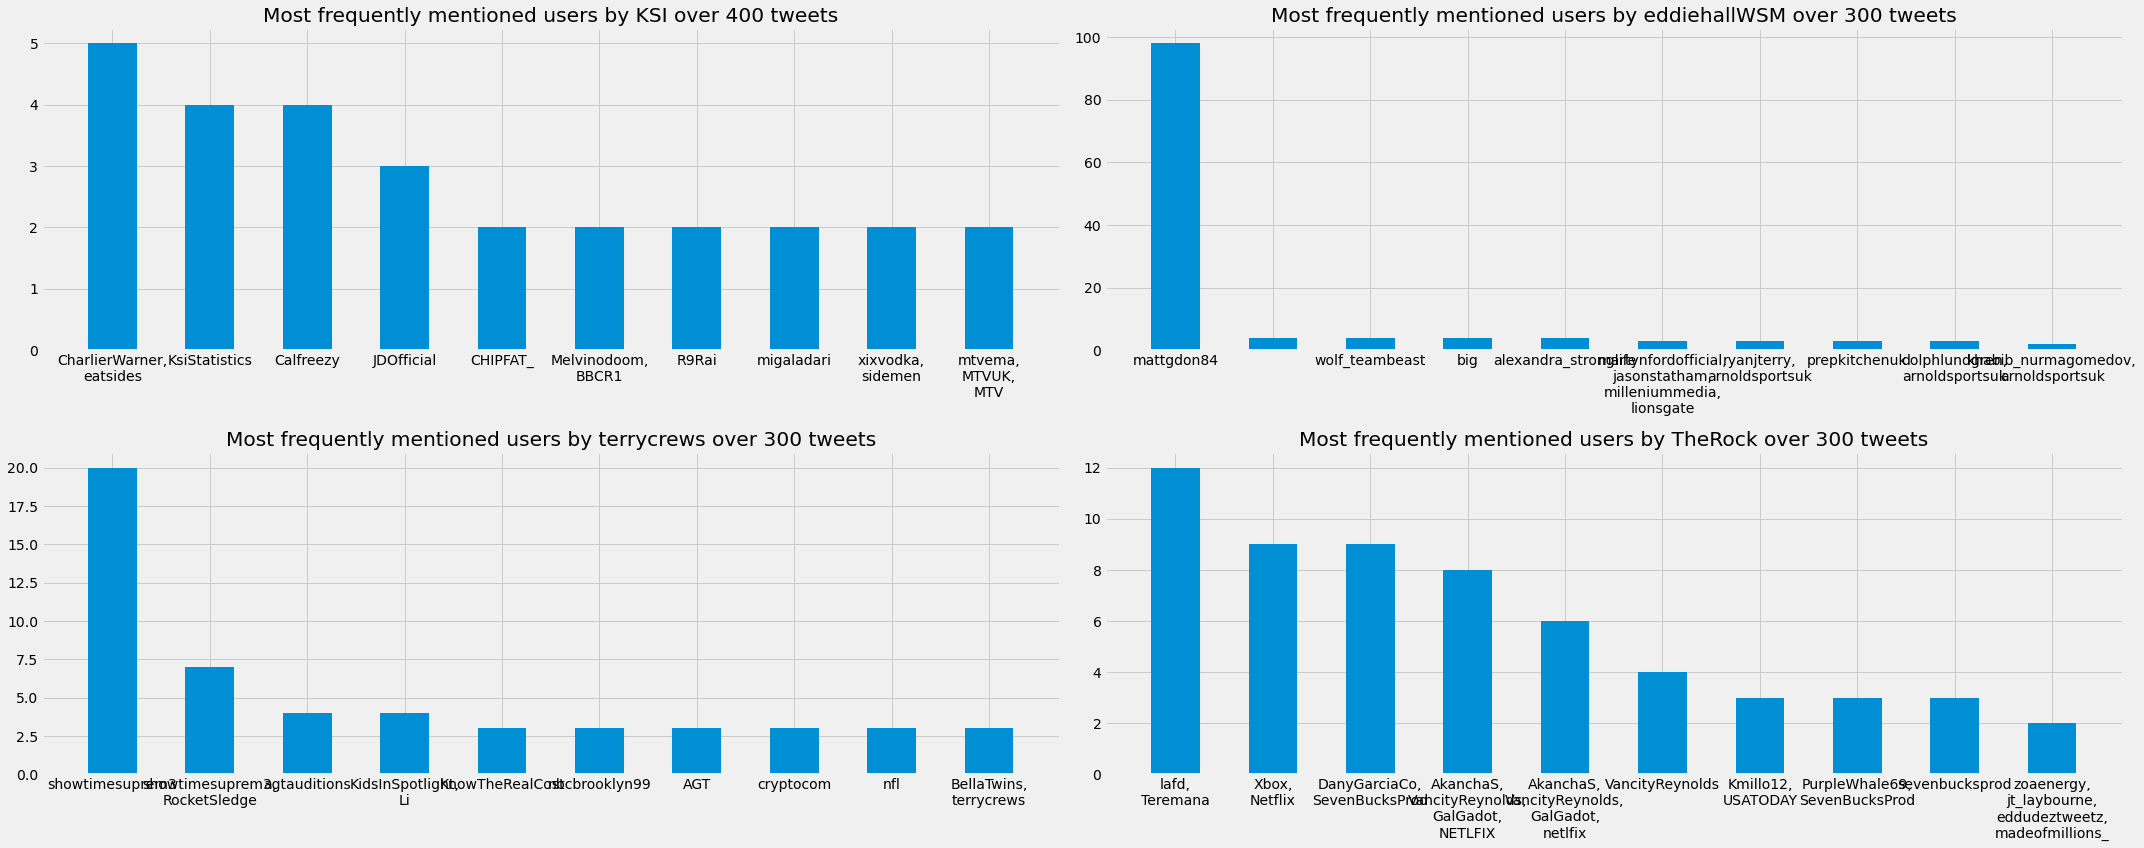

In [7]:
# Are there any 'favourite' accounts mentioned by these users?
plot_top_most_mentioned_users(names)

In [8]:
# Which tweets for each user, have the most likes
tweets = get_top_n_tweets(names, 5)
# tweets

Reading twitter data from file


Reading twitter data from file


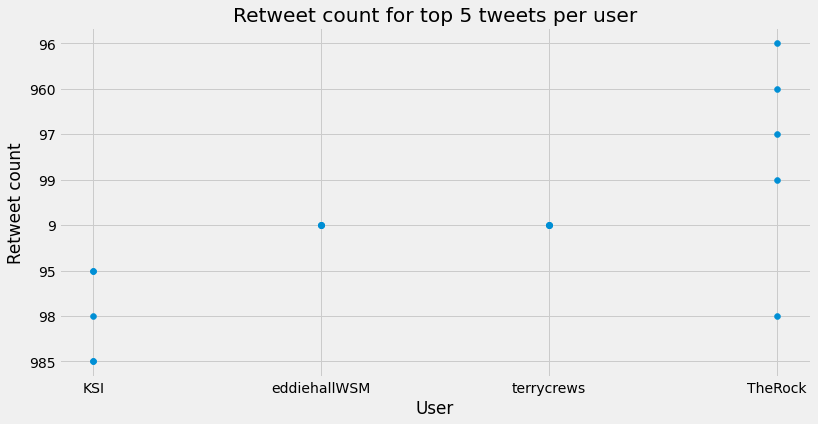

In [9]:
# Which tweets have been retweeted the most
n = 5
tweets = get_top_n_retweeted_tweets(names, n)
# tweets
plt.figure(figsize=(12,6))
plt.scatter(tweets['User'], tweets['retweets'])
plt.xlabel("User")
plt.ylabel("Retweet count")
plt.title(f"Retweet count for top {n} tweets per user")
plt.show()

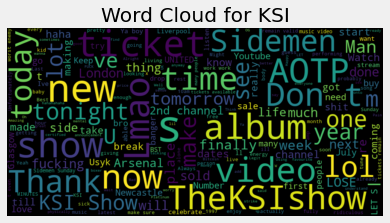

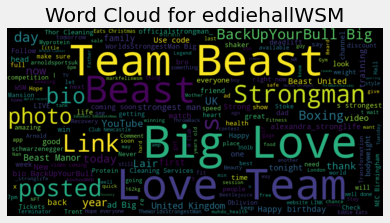

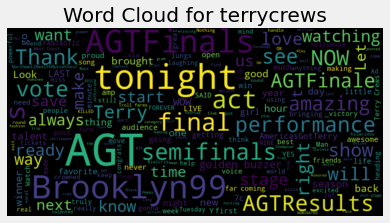

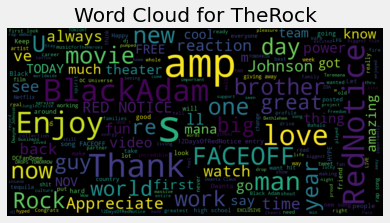

In [10]:
# Which account is the most successful considering the previous two points?
#   Assumption is that sum of likes and retweets dictates a tweet's popularity

# OTHER analysis? (Optional but always good)
# Ideas
#   Map with coordinates highlighted on map
#   Text blob popular words from single users tweets
# Creates two new columns for subjectivity and polarity values of each tweet
# Clean the data (Although I keep some of the various things in the tweets because it dictates the type of tweets they are)
df['tweets'] = df['tweets'].apply(clean_tweet_data)
df = drop_useless_rows(df)
df['Subjectivity'] = df['tweets'].apply(getSubjectivity)
df['Polarity'] = df['tweets'].apply(getPolarity)
# Create word cloud based on least to most frequenetly used words
generate_word_clouds(names)

# Task 3

In [11]:
import networkx as nx

# Get the 'mention' data for the specified user
user = 'KSI'
df = get_users_twitter_data([user], 100)

# Calculate total tweets we're deriving the following information from
tweet_count = len(df[df['User'] == user])
# Get the 'mention' data for the specified user
tempdf = get_user_mentions_by_user(user, df)
# Extracts all user mentions from tweets and stores to new column
tempdf['mention'] = tempdf.tweets.str.findall(r'(?<![@\w])@(\w{1,25})').apply(',\n'.join)
# Calculate the number of mentions each account has by this user
mention_values = tempdf['mention'].value_counts()
# Retrieve each unique mentioned user from the list
mention_unique = tempdf['mention'].unique()

print(mention_values)
print(mention_unique)

Getting Twitter Data
Screen name	Followers
KSI	7260370
R9Rai                        2
CHIPFAT_                     2
PrincesTrust                 1
producerSX                   1
JDOfficial                   1
reallorraine                 1
jxck_yt                      1
thcwknd                      1
primevideouk,\nKSI           1
KsiStatistics                1
Cian_1997                    1
LilTunechi                   1
Calfreezy                    1
CharlierWarner,\neatsides    1
migaladari                   1
RiceGum                      1
Ray33k1                      1
Jacksepticeye                1
LORDKIFORN,\nCian_1997       1
DegenApeAcademy              1
agenious0123448              1
Melvinodoom,\nBBCR1          1
filmusic_ksi                 1
mtvema,\nMTVUK,\nMTV         1
emmalou25                    1
BBCR1                        1
xixvodka,\nsidemen           1
TubboLive                    1
khubebabbasi                 1
Name: mention, dtype: int64
['CharlierWarner,\

In [12]:

# def plot_likes_over_time():
#     users = ["KSI"]
#     df = read_twitter_data(users)
#     df
#     likes = []
#     create_times = []

#     for user in users:
#         temp = df[df["User"] == user]
#         temp = temp.astype({'likes': 'int32'})
#         temp['create_time']= pd.to_datetime(temp['create_time'])

#         create_list = temp["create_time"].tolist()
#         create_times.append(create_list)

#         like_list = temp["likes"].tolist()
#         likes.append(like_list)
        
#     dates_likes = list(zip(create_times, likes))
#     sorted_zipped_lists = sorted(dates_likes)
#     sorted_list1 = [element for _, element in sorted_zipped_lists]

#     print(sorted_list1)
#     # plt.plot(create_times, likes, label = "ye")
#     # plt.ylabel("")
#     plt.show()


# plot_likes_over_time()

FileNotFoundError: [Errno 2] No such file or directory: 'eddiehallWSM_account.txt'

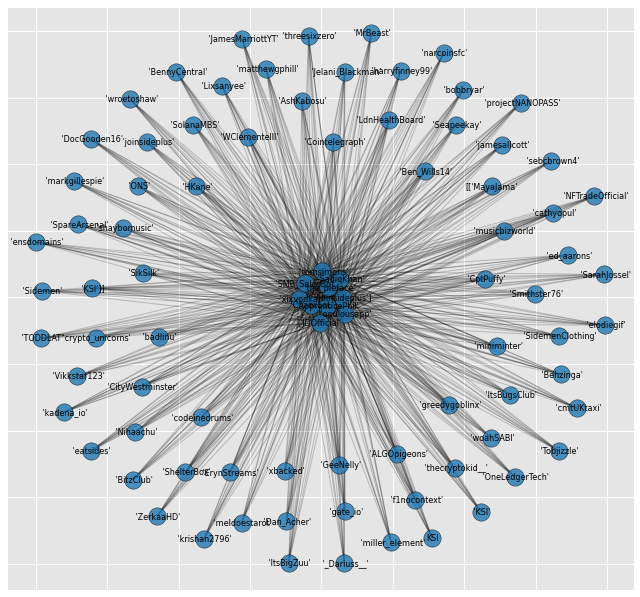

In [72]:
# friends = []
# count = 0
# print("started")
user_friends = []
friend_friends = [[]]
n = 10
count = 0
# Collect top 50 friends / following accounts from KSI account
# names = ["KSI", "KSICrypto", "TheRock"]
for name in names:
    # For each person the user 'name' is following (up to n)
    for user in tweepy.Cursor(api.get_friends, screen_name="KSI").items(n):
        # Append that users name to list
        user_friends.append(user.screen_name)
        # For each person this user is following (up to n)
        for friend in tweepy.Cursor(api.get_friends, screen_name=user.screen_name).items(n):
            # append friend to inner list of 2D list (each element represents a user's following list)
            friend_friends[count].append(friend.screen_name)

    # Save user's friends to text file
    with open(f"{name}_account.txt", "w") as output:
        output.write(str(user_friends))
    # Save user's friends' friends to text file
    with open(f"{name}_account_friends.txt", "w") as output:
        output.write(str(friend_friends))

    df = pd.DataFrame()
    text_file = open(f"{name}_account.txt", "r")
    user_friends = text_file.read().split(',')
    text_file.close()

    text_file = open(f"{name}_account_friends.txt", "r")
    friend_friends = text_file.read().split(',')
    text_file.close()

    for i in user_friends:
        if "[" in i or "]" in i:
            i.replace("[", "").replace("]", "")
    for i in friend_friends:
        if "[" in i or "]" in i:
            i.replace("[", "").replace("]", "")


    # Create new column called friends populated with friends' list of values
    df["friends"] = user_friends
    df.insert(0, "user", "KSI")
    for friend in user_friends:
        temp1 = []
        temp2 = []
        temp = pd.DataFrame()
        for friend2 in friend_friends:
            temp1.append(friend)
            temp2.append(friend2)
        temp["user"] = temp1
        temp["friends"] = temp2
        df = df.append(temp, ignore_index=True)

    # df.shape
    # df
    # Insert new column: "User" with value "KSI" at index 0
    G = nx.from_pandas_edgelist(df, 'user', 'friends') #Turn df into graph
    pos = nx.spring_layout(G) #specify layout for visual

    # Create the graph with the data we've just created/generated
    f, ax = plt.subplots(figsize=(10, 10))
    # Type of plot
    plt.style.use('ggplot')
    # Takes G (The graph), pos (layout style) and alpha (transparency of each node) as parameter to draw network
    nodes = nx.draw_networkx_nodes(G, pos, alpha=0.8)
    nodes.set_edgecolor('k')
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)
    plt.savefig("Graph.png", format="PNG")
